In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import random
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

In [3]:
#!unzip /content/gdrive/MyDrive/bangkit/model/DatasetV2Trimmed5.zip
!unzip /content/gdrive/MyDrive/DatasetV2Trimmed5.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Metal_AluminiumCans/AluCan964.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan965.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan966.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan967.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan968.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan969.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan97.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan970.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan971.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan972.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan973.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan974.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan975.jpg  
  inflating: /content/dataset/Metal_AluminiumCans/AluCan976.jpg  
  inflating: /content/data

In [4]:
base_dir="/content/dataset"
os.listdir('/content/dataset')

['Metal_AluminiumCans',
 'Plastic_PET',
 'Textiles_Textiles',
 'Paper_Paper',
 'Glass_ClearGlass']

In [5]:
IMAGE_SIZE=224
BATCH_SIZE=50

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    shear_range=0.2,
    horizontal_flip=True,
)

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_datagen=train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

test_datagen=test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'

)


Found 6796 images belonging to 5 classes.
Found 678 images belonging to 5 classes.


In [6]:
class_indices = train_datagen.class_indices
class_labels = list(class_indices.keys())

print("Class Indices:", class_indices)
print("Class Labels:", class_labels)

Class Indices: {'Glass_ClearGlass': 0, 'Metal_AluminiumCans': 1, 'Paper_Paper': 2, 'Plastic_PET': 3, 'Textiles_Textiles': 4}
Class Labels: ['Glass_ClearGlass', 'Metal_AluminiumCans', 'Paper_Paper', 'Plastic_PET', 'Textiles_Textiles']


In [8]:
#Will do transfer learning from MobileNetV2
base = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base.trainable = False
model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Flatten(),
    base,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax') #Change this according to number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,619,461
Trainable params: 361,477
Non-trainable params: 2,257,984
______________________________________

In [9]:
#callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_checkpoint,h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

In [10]:
history = model.fit(
    train_datagen,
    epochs=15,
    validation_data=test_datagen,
    callbacks=[checkpoint,early_stopping])

Epoch 1/15
136/136 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.8949
Epoch 1: val_loss improved from inf to 0.13883, saving model to model_checkpoint,h5


136/136 [==============================] - 249s 2s/step - loss: 0.2910 - accuracy: 0.8949 - val_loss: 0.1388 - val_accuracy: 0.9454
Epoch 2/15
136/136 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.9450
Epoch 2: val_loss improved from 0.13883 to 0.07612, saving model to model_checkpoint,h5


136/136 [==============================] - 227s 2s/step - loss: 0.1533 - accuracy: 0.9450 - val_loss: 0.0761 - val_accuracy: 0.9720
Epoch 3/15
136/136 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9556
Epoch 3: val_loss did not improve from 0.07612
136/136 [==============================] - 203s 1s/step - loss: 0.1253 - accuracy: 0.9556 - val_loss: 0.1315 - val_accuracy: 0.9513
Epoch 4/15
136/136 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9653
Epoch 4: val_loss improved from 0.07612 to 0.06645, saving model to model_checkpoint,h5


136/136 [==============================] - 225s 2s/step - loss: 0.1038 - accuracy: 0.9653 - val_loss: 0.0665 - val_accuracy: 0.9749
Epoch 5/15
136/136 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9651
Epoch 5: val_loss improved from 0.06645 to 0.06505, saving model to model_checkpoint,h5


136/136 [==============================] - 224s 2s/step - loss: 0.0990 - accuracy: 0.9651 - val_loss: 0.0651 - val_accuracy: 0.9794
Epoch 6/15
136/136 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9726
Epoch 6: val_loss improved from 0.06505 to 0.06245, saving model to model_checkpoint,h5


136/136 [==============================] - 226s 2s/step - loss: 0.0839 - accuracy: 0.9726 - val_loss: 0.0625 - val_accuracy: 0.9794
Epoch 7/15
136/136 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9722
Epoch 7: val_loss improved from 0.06245 to 0.03258, saving model to model_checkpoint,h5


136/136 [==============================] - 225s 2s/step - loss: 0.0805 - accuracy: 0.9722 - val_loss: 0.0326 - val_accuracy: 0.9912
Epoch 8/15
136/136 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9741
Epoch 8: val_loss improved from 0.03258 to 0.02687, saving model to model_checkpoint,h5


136/136 [==============================] - 223s 2s/step - loss: 0.0733 - accuracy: 0.9741 - val_loss: 0.0269 - val_accuracy: 0.9912
Epoch 9/15
136/136 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9751
Epoch 9: val_loss did not improve from 0.02687
136/136 [==============================] - 204s 2s/step - loss: 0.0748 - accuracy: 0.9751 - val_loss: 0.0480 - val_accuracy: 0.9779
Epoch 10/15
136/136 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9795
Epoch 10: val_loss did not improve from 0.02687
136/136 [==============================] - 202s 1s/step - loss: 0.0596 - accuracy: 0.9795 - val_loss: 0.0311 - val_accuracy: 0.9867
Epoch 11/15
136/136 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9791
Epoch 11: val_loss did not improve from 0.02687
136/136 [==============================] - 204s 1s/step - loss: 0.0582 - accuracy: 0.9791 - val_loss: 0.0340 - val_accuracy: 0.9897
Epoch 12/15
136/136 [==================

136/136 [==============================] - 224s 2s/step - loss: 0.0571 - accuracy: 0.9795 - val_loss: 0.0254 - val_accuracy: 0.9897
Epoch 13/15
136/136 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9779
Epoch 13: val_loss improved from 0.02540 to 0.01610, saving model to model_checkpoint,h5


136/136 [==============================] - 227s 2s/step - loss: 0.0593 - accuracy: 0.9779 - val_loss: 0.0161 - val_accuracy: 0.9956
Epoch 14/15
136/136 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9818
Epoch 14: val_loss did not improve from 0.01610
136/136 [==============================] - 204s 1s/step - loss: 0.0464 - accuracy: 0.9818 - val_loss: 0.0263 - val_accuracy: 0.9912
Epoch 15/15
136/136 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9819
Epoch 15: val_loss did not improve from 0.01610
136/136 [==============================] - 201s 1s/step - loss: 0.0528 - accuracy: 0.9819 - val_loss: 0.0353 - val_accuracy: 0.9867


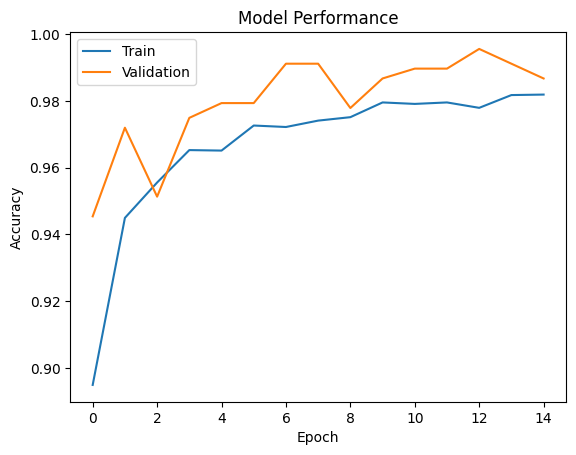

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()


In [12]:
uploaded = files.upload()

class_labels = ['Glass_ClearGlass', 'Metal_AluminiumCans',
                'Paper_Paper', 'Plastic_PET','Textiles_Textiles']

'''class_labels = ['AHP_AHP', 'Composite_CompositeFnBCarton', 'Composite_Matresses',
                'Glass_BrownGlass', 'Glass_ClearGlass', 'Glass_GreenGlass',
                'IronMetal_StainlessSteel', 'IronMetal_Steel', 'Metal_AluminiumCans',
                'NonIronMetal_AlumuniumNonCan', 'NonIronMetal_Wiring', 'Paper_Cardboard',
                'Paper_Paper', 'Plastic_HDPEM', 'Plastic_PET', 'Textiles_Footwear',
                'Textiles_Textiles'] '''#Original complete version

for fn in uploaded.keys():
    # Predicting images
    path = fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    predictions = model.predict(images, batch_size=10)
    predicted_class_index = np.argmax(predictions[0])
    predicted_label = class_labels[predicted_class_index]

    print("Filename:", fn)
    print("Predicted Class:", predicted_label)
    print("Prediction Scores:", predictions[0])

In [13]:
#generate saved model
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

In [15]:
model.save('model.h5')

In [14]:
#convert savedmodel to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

In [16]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2874536

In [17]:
#download TFLite model
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>